In [23]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

In [24]:
plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

In [25]:
def show(imgs: List[torch.Tensor]):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))                 # -> cpu -> PILImage
        axs[0, i].imshow(np.asarray(img))                   # -> np.asarray
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [26]:
car = read_image('car.jpg')
print(type(car))

<class 'torch.Tensor'>


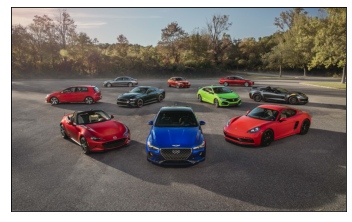

In [27]:
show([car])

In [7]:
print(car.shape, car.dtype)

torch.Size([3, 2139, 3500]) torch.uint8


## Transform images on GPU

In [13]:
import torch.nn as nn

transforms = torch.nn.Sequential(
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.3),
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
car = car.to(device)

In [14]:
device

'cuda'

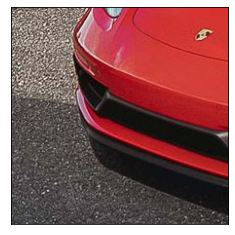

In [16]:
transformed_car = transforms(car)
show([transformed_car])

## Scriptable transform(for easy deployment via torchscript)

In [17]:
from torchvision.models import resnet18


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(pretrained=True, progress=False).eval()
        self.transforms = nn.Sequential(
            T.Resize([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

In [18]:
predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([car]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/curt/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
/home/curt/.pyenv/versions/3.8.3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [21]:
import json
from pathlib import Path

#with open(Path('assets') / 'imagenet_class_index.json', 'r') as labels_file:
#    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction {i + 1}: {str(pred.item())}")

Prediction 1: 656


In [22]:
import tempfile

with tempfile.NamedTemporaryFile() as f:
    scripted_predictor.save(f.name)

    dumped_scripted_predictor = torch.jit.load(f.name)
    res_scripted_dumped = dumped_scripted_predictor(batch)
assert (res_scripted_dumped == res_scripted).all()